In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Seat.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Altea,Seri_Arosa,Seri_Cordoba,...,Model_2.0 SXE,Model_2.0 TDI Stylance,Model_2.0 TFSI Cupra,Model_2.0 TSI Cupra,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,788000,2016,110,1598,80000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,610000,2018,95,1598,207000,3.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,285000,2006,85,1390,220000,9.0,0.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,649000,2018,95,999,93947,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,625000,2015,105,1598,235000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_18164\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,53671.881342,3.805209e+09,61686.372344,40547.016244


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:23:18,146] A new study created in memory with name: no-name-7e6effa0-f58a-450e-8156-d8c170da24d1
[I 2023-10-08 14:23:18,306] Trial 1 finished with value: 535406.2738127501 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.0028296893418447906, 'max_depth': 6, 'min_child_weight': 194}. Best is trial 1 with value: 535406.2738127501.
[I 2023-10-08 14:23:18,320] Trial 0 finished with value: 442984.19140189775 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.022681741571124465, 'max_depth': 8, 'min_child_weight': 93}. Best is trial 0 with value: 442984.19140189775.
[I 2023-10-08 14:23:18,323] Trial 2 finished with value: 518386.73692663125 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.006254800734469137, 'max_depth': 15, 'min_child_weight': 157}. Best is trial 0 with value: 442984.19140189775.
[I 2023-10-08 14:23:18,333] Trial 3 finished with value: 220601.38594938765 and parameters: 

[I 2023-10-08 14:23:19,382] Trial 29 finished with value: 170621.19133234335 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.12692060751514034, 'max_depth': 13, 'min_child_weight': 128}. Best is trial 18 with value: 80339.4545909597.
[I 2023-10-08 14:23:19,390] Trial 31 finished with value: 174145.62077514202 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.12671419267165748, 'max_depth': 13, 'min_child_weight': 168}. Best is trial 18 with value: 80339.4545909597.
[I 2023-10-08 14:23:19,475] Trial 32 finished with value: 184493.67750184322 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.11761546333318673, 'max_depth': 13, 'min_child_weight': 127}. Best is trial 18 with value: 80339.4545909597.
[I 2023-10-08 14:23:19,522] Trial 33 finished with value: 163624.26152803452 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1351184735967313, 'max_depth': 13, 'min_child_wei

[I 2023-10-08 14:23:20,966] Trial 60 finished with value: 95107.08788853114 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.31207666330475103, 'max_depth': 8, 'min_child_weight': 239}. Best is trial 18 with value: 80339.4545909597.
[I 2023-10-08 14:23:21,003] Trial 62 finished with value: 85011.24252150237 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3234868080525213, 'max_depth': 14, 'min_child_weight': 204}. Best is trial 18 with value: 80339.4545909597.
[I 2023-10-08 14:23:21,008] Trial 61 finished with value: 93202.09748716783 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3233406931753065, 'max_depth': 8, 'min_child_weight': 238}. Best is trial 18 with value: 80339.4545909597.
[I 2023-10-08 14:23:21,021] Trial 64 finished with value: 86951.4649057603 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.31185743068881033, 'max_depth': 11, 'min_child_weight': 20

[I 2023-10-08 14:23:22,562] Trial 90 finished with value: 73734.88962084748 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.3873710032106403, 'max_depth': 6, 'min_child_weight': 69}. Best is trial 90 with value: 73734.88962084748.
[I 2023-10-08 14:23:22,667] Trial 91 finished with value: 76564.50083130278 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.38524374118087473, 'max_depth': 7, 'min_child_weight': 103}. Best is trial 90 with value: 73734.88962084748.
[I 2023-10-08 14:23:22,683] Trial 92 finished with value: 76447.03475304472 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.3970640333350041, 'max_depth': 7, 'min_child_weight': 100}. Best is trial 90 with value: 73734.88962084748.
[I 2023-10-08 14:23:22,746] Trial 93 finished with value: 75835.59922011255 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.40047938890137535, 'max_depth': 6, 'min_child_weight': 1

[I 2023-10-08 14:23:24,357] Trial 121 finished with value: 75550.04515257207 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.47579880382244805, 'max_depth': 4, 'min_child_weight': 88}. Best is trial 119 with value: 69886.32390061018.
[I 2023-10-08 14:23:24,370] Trial 120 finished with value: 70072.78299846934 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.48446019788213274, 'max_depth': 4, 'min_child_weight': 41}. Best is trial 119 with value: 69886.32390061018.
[I 2023-10-08 14:23:24,435] Trial 122 finished with value: 75789.78781124692 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.46493136483931674, 'max_depth': 4, 'min_child_weight': 88}. Best is trial 119 with value: 69886.32390061018.
[I 2023-10-08 14:23:24,544] Trial 123 finished with value: 69629.64392533094 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.48809332450894494, 'max_depth': 4, 'min_child_wei

[I 2023-10-08 14:23:26,325] Trial 150 finished with value: 96137.03191955785 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.20267095866313029, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 130 with value: 69515.63954513856.
[I 2023-10-08 14:23:26,463] Trial 151 finished with value: 71252.3873295391 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.49738899413205356, 'max_depth': 3, 'min_child_weight': 35}. Best is trial 130 with value: 69515.63954513856.
[I 2023-10-08 14:23:26,481] Trial 153 finished with value: 102216.0587953346 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.1964406738851298, 'max_depth': 3, 'min_child_weight': 35}. Best is trial 130 with value: 69515.63954513856.
[I 2023-10-08 14:23:26,584] Trial 155 finished with value: 66820.06552119477 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4926055806941702, 'max_depth': 4, 'min_child_weight

[I 2023-10-08 14:23:28,430] Trial 180 finished with value: 66695.65241196177 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.397919240235217, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 179 with value: 63963.37107299664.
[I 2023-10-08 14:23:28,430] Trial 181 finished with value: 66365.16198709635 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.40148262256012085, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 179 with value: 63963.37107299664.
[I 2023-10-08 14:23:28,473] Trial 182 finished with value: 65939.95289529182 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3982646146262253, 'max_depth': 5, 'min_child_weight': 9}. Best is trial 179 with value: 63963.37107299664.
[I 2023-10-08 14:23:28,624] Trial 183 finished with value: 67449.56957011076 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3884296483275301, 'max_depth': 5, 'min_child_weight': 8

[I 2023-10-08 14:23:30,466] Trial 210 finished with value: 68310.9053499453 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.35338313119637765, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 187 with value: 63563.959260624695.
[I 2023-10-08 14:23:30,532] Trial 211 finished with value: 515736.41011874244 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.00659744405437302, 'max_depth': 5, 'min_child_weight': 2}. Best is trial 187 with value: 63563.959260624695.
[I 2023-10-08 14:23:30,600] Trial 213 finished with value: 67112.59116879784 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3721349460989631, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 187 with value: 63563.959260624695.
[I 2023-10-08 14:23:30,633] Trial 212 finished with value: 68330.77063137654 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3527780043378561, 'max_depth': 5, 'min_child_weig

[I 2023-10-08 14:23:32,603] Trial 239 finished with value: 66093.82524193102 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3181994403655164, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 229 with value: 62929.403641752855.
[I 2023-10-08 14:23:32,732] Trial 241 finished with value: 67116.94026188813 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.319226579088959, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 229 with value: 62929.403641752855.
[I 2023-10-08 14:23:32,762] Trial 242 finished with value: 67284.13654253595 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.30651832817944286, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 229 with value: 62929.403641752855.
[I 2023-10-08 14:23:32,941] Trial 243 finished with value: 66106.72396286932 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3234225627933739, 'max_depth': 6, 'min_child_weight'

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 62929.4036
Best params:
	colsample_bytree: 0.9
	subsample: 0.6
	learning_rate: 0.42273221075234835
	max_depth: 6
	min_child_weight: 7


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 59078.62947643321, 'MSE': 4204840693.883761, 'RMSE': 64844.74299342824, 'MAE': 42731.4743852459}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9135686685531185

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8996547570787228

In [16]:
marka_model = joblib.dump(final_model, "Seat.pkl")

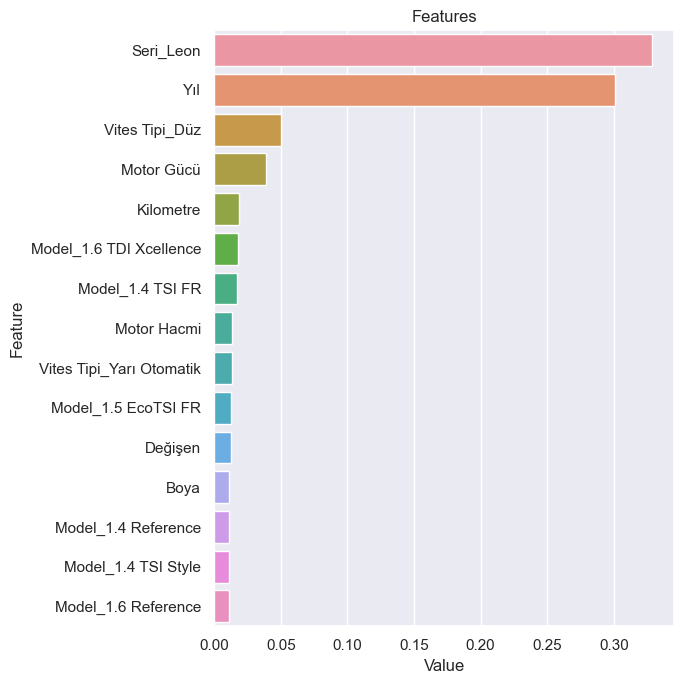

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)